100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


MSE: 1.1404
MAE: 0.7670
MAPE: 2138.4280%
RMSE: 1.0679
R-squared: -0.1326


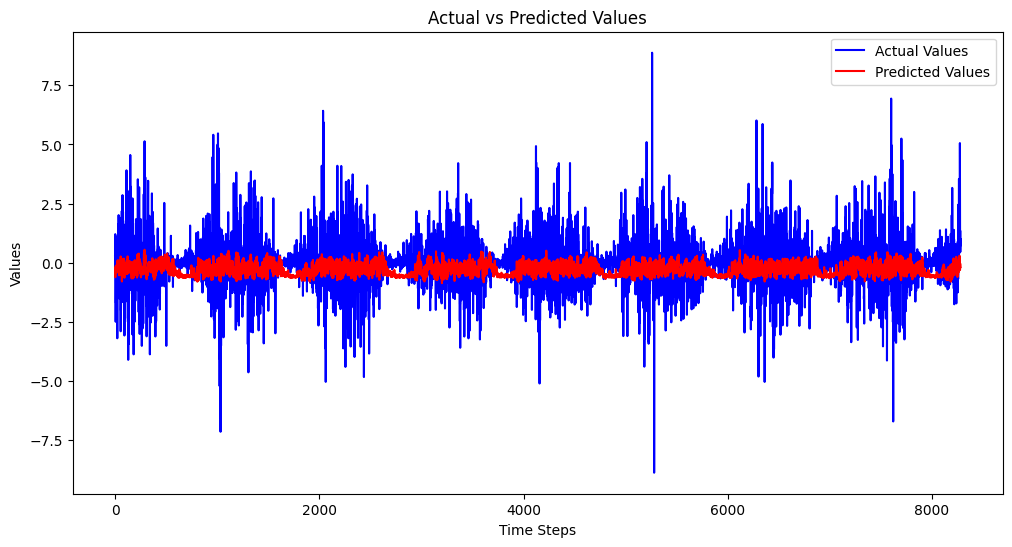

In [2]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

import numpy as np
import matplotlib.pyplot as plt

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = MPNNLSTM(node_features, 32, 20, 1, 0.5)
        self.linear = torch.nn.Linear(2*32 + node_features, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
        
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost += torch.mean((y_hat - snapshot.y) ** 2)  # MSE for training loss
    cost /= (time + 1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

# Evaluation phase
model.eval()
predictions = []
actuals = []

for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    
    # Store predictions and actual values
    predictions.append(y_hat.detach().cpu().numpy())
    actuals.append(snapshot.y.detach().cpu().numpy())

# Convert lists to numpy arrays for easier handling if needed
predictions = np.array(predictions).squeeze()  # Remove extra dimensions if necessary
actuals = np.array(actuals).squeeze()

# Calculate evaluation metrics
mse = np.mean((predictions - actuals) ** 2)  # Mean Squared Error
mae = np.mean(np.abs(predictions - actuals))  # Mean Absolute Error
mape = np.mean(np.abs((predictions - actuals) / actuals)) * 100  # Mean Absolute Percentage Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# R-squared (Coefficient of Determination)
ss_total = np.sum((actuals - np.mean(actuals)) ** 2)
ss_residual = np.sum((actuals - predictions) ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Print evaluation metrics
print("MSE: {:.4f}".format(mse))
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("R-squared: {:.4f}".format(r_squared))

# Optional: Visualize results
plt.figure(figsize=(12, 6))
plt.plot(actuals.flatten(), label='Actual Values', color='blue')
plt.plot(predictions.flatten(), label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()